In [133]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

# Task 1

## a)

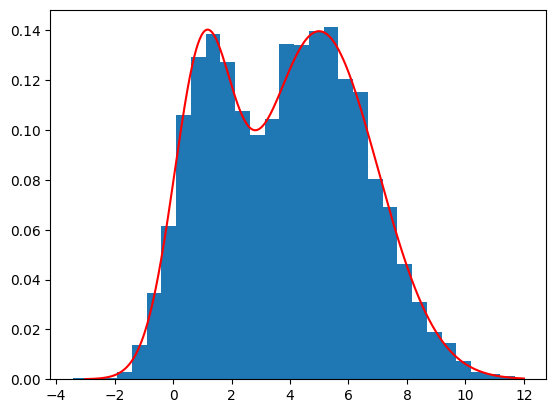

In [148]:
def joint_pdf(x):
    return 0.3 * norm.pdf(x, 1, 1) + 0.7 * norm.pdf(x, 5, 2)

n = 5000

mu_0 = 1
sigma_0 = 1

mu_1 = 5
sigma_1 = 2

pi_0 = 0.3
pi_1 = 0.7

def generate_data(n, mu_0, mu_1, sigma_0, sigma_1, pi_0, pi_1):
    idx = np.random.choice(2, n, p = [pi_0, pi_1])

    norm_0 = np.random.normal(mu_0, sigma_0, n)
    norm_1 = np.random.normal(mu_1, sigma_1, n)

    sample = np.zeros(n)
    sample[idx == 0] = norm_0[idx == 0]
    sample[idx == 1] = norm_1[idx == 1]
    return sample

sample = generate_data(n, mu_0, mu_1, sigma_0, sigma_1, pi_0, pi_1)

plt.hist(sample, bins=30, density=True)

x = np.linspace(-3, 12, 500)
y = joint_pdf(x)
plt.plot(x, y, c="red")
plt.show()

## b)

$$\sum_{i=1}^n \log p(x_i, G_i | \theta) = \sum_{i=1}^n \left( (1-g_i)(\log N(\mu_0, \sigma_0^2) + \log \pi_0) + g_i(\log N(\mu_1, \sigma_1^2) + \log \pi_1) \right)$$

# c) d) e)

$$\gamma_i = \frac{\pi_0 N(\mu_0, \sigma_0^2)}{\pi_0 N(\mu_0, \sigma_0^2) + \pi_1 N(\mu_1, \sigma_1^2) } $$

In [135]:
def ll(x, g):
    p = np.zeros_like(x)
    p[g == 0] = np.log(norm.pdf(x[g == 0], mu_0, sigma_0 ** (1 / 2))) + np.log(pi_0)
    p[g == 1] = np.log(norm.pdf(x[g == 1], mu_1, sigma_1 ** (1 / 2))) + np.log(pi_1)
    return np.sum(p)

def ll_hat(x, theta):
    mu_0, mu_1, sigma_0, sigma_1, pi_0, pi_1, gamma = theta
    p = np.zeros_like(x)
    p += gamma * (np.log(norm.pdf(x, mu_0, sigma_0 ** (1 / 2)))) + np.log(pi_0)
    p += (1 - gamma) * (np.log(norm.pdf(x, mu_1, sigma_1 ** (1 / 2)))) + np.log(pi_1)
    return np.sum(p)

def update_gamma(x, theta):
    mu_0, mu_1, sigma_0, sigma_1, pi_0, pi_1, gamma = theta
    return (
        pi_1
        * norm.pdf(x, loc=mu_1, scale=np.sqrt(sigma_1))
        / (
            pi_0 * norm.pdf(x, loc=mu_0, scale=np.sqrt(sigma_0))
            + pi_1 * norm.pdf(x, loc=mu_1, scale=np.sqrt(sigma_1))
        )
    )

def update_sigma_0(x, theta):
    mu_0, mu_1, sigma_0, sigma_1, pi_0, pi_1, gamma = theta
    return np.sum((1 - gamma) * (x - mu_0) ** 2) / np.sum(1 - gamma)

def update_sigma_1(x, theta):
    mu_0, mu_1, sigma_0, sigma_1, pi_0, pi_1, gamma = theta
    return np.sum(gamma * (x - mu_1) ** 2) / np.sum(gamma)

def update_mu_0(x, theta):
    mu_0, mu_1, sigma_0, sigma_1, pi_0, pi_1, gamma = theta
    return np.sum((1 - gamma) * x) / np.sum(1 - gamma)

def update_mu_1(x, theta):
    mu_0, mu_1, sigma_0, sigma_1, pi_0, pi_1, gamma = theta
    return np.sum(gamma * x) / np.sum(gamma)

def update_pi_0(x, theta):
    mu_0, mu_1, sigma_0, sigma_1, pi_0, pi_1, gamma = theta
    return np.mean(1- gamma)

def update_pi_1(x, theta):
    mu_0, mu_1, sigma_0, sigma_1, pi_0, pi_1, gamma = theta
    return np.mean(gamma)

In [136]:
n = 5000

gt_mu_0 = 1
gt_sigma_0 = 1

gt_mu_1 = 5
gt_sigma_1 = 2

gt_pi_0 = 0.3
gt_pi_1 = 0.7

sample = generate_data(n, gt_mu_0, gt_mu_1, gt_sigma_0, gt_sigma_1, gt_pi_0, gt_pi_1)

N = 1000
theta = [1., -1., 1., 5., 0.5, 0.5, None]

last_ll = float('-Inf')

for i in range(N):
    theta[-1] = update_gamma(sample, theta)

    mu_0, mu_1, sigma_0, sigma_1, pi_0, pi_1 = (
        update_mu_0(sample, theta),
        update_mu_1(sample, theta),
        update_sigma_0(sample, theta),
        update_sigma_1(sample, theta),
        update_pi_0(sample, theta),
        update_pi_1(sample, theta)
    )
    
    theta[:-1] = mu_0, mu_1, sigma_0, sigma_1, pi_0, pi_1

    loglik = ll_hat(sample, theta)

    if abs(loglik - last_ll) < 1e-2:
        break

    last_ll = loglik

In [137]:
print(gt_mu_0, gt_mu_1, gt_sigma_0, gt_sigma_1, gt_pi_0, gt_pi_1)
theta[:-1]

1 5 1 2 0.3 0.7


[1.0187712425685087,
 5.075964303844343,
 0.9727972995718553,
 4.027467993570472,
 0.3183028571559043,
 0.6816971428440958]